# **Detection of co-seismic Landslides by using the machine learning tool Tensorflow**

### Importing Tensorflow & Other Libraries

In [ ]:
#Setup - Importing the required libraries
import numpy as np
import math
import os
import PIL
import PIL.Image
from PIL import Image
import gdal
import gdalconst
import ogr
import keras
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import sys
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr
from osgeo.gdalconst import *

#Tensorflow setup
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.compat.v1.keras.backend import set_session
from keras.models import Sequential
from keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Activation, BatchNormalization, Reshape
from keras import backend as K
import tensorflow_datasets as tfds
print('Tensorflow version:',tf.__version__)

Tensorflow version: 2.8.2


### Connect to Google Drive


In [ ]:
#Connect to Google drive for files
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive


Mounted at /content/drive
/content/drive


### Opening, Configuring and Standardizing the data

In [ ]:
#open Images and transform to array
dts = gdal.Open("MyDrive/Colab_Data/pre_event-image_1.tif")
dts2 = gdal.Open("MyDrive/Colab_Data/pre_event-ndvi_1.tif")
dts3 = gdal.Open("MyDrive/Colab_Data/post_event-image.tif")
dts4 = gdal.Open("MyDrive/Colab_Data/post_event-ndvi_1.tif")
dts5 = gdal.Open("MyDrive/Colab_Data/DEM_Hokkaido.tif")
dts6 = gdal.Open("MyDrive/Colab_Data/Slope_Hokkaido.tif")
dtsarra = dts.ReadAsArray()
dtsarra2 = dts2.ReadAsArray()
dtsarra3 = dts3.ReadAsArray()
dtsarra4 = dts4.ReadAsArray()
dtsarra5 = dts5.ReadAsArray()
dtsarra6 = dts6.ReadAsArray()

The number of dimensions is: 3
The shape of the image is: (3, 3891, 4396)
The minimum value of RGB is: 0
The maximum value of RGB is: 255
The geotransformation is: (141.78774882568655, 8.983152841195215e-05, 0.0, 42.921863601344384, 0.0, -8.983152841195215e-05)
The projection is: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]
The shape of the DEM is: (3891, 4396)
The shape of the Slope is: (3891, 4396)


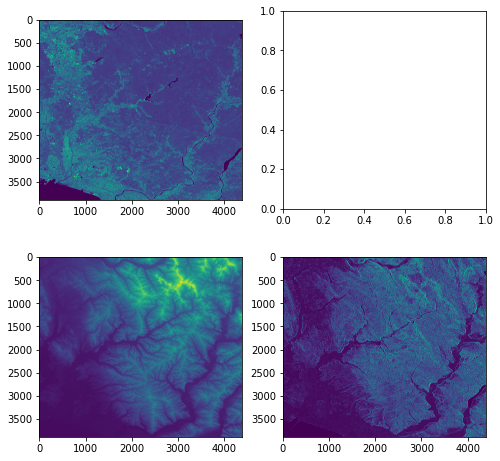

In [ ]:
#Checking dimensions of the images
print("The number of dimensions is:",dtsarra.ndim)
print("The shape of the image is:",dtsarra.shape)
print("The minimum value of RGB is:",np.min(dtsarra))
print("The maximum value of RGB is:",np.max(dtsarra))
geotransform = dts.GetGeoTransform()
print("The geotransformation is:",geotransform)
proj = dts.GetProjection()
print("The projection is:",proj)
print("The shape of the DEM is:", dtsarra5.shape)
print("The shape of the Slope is:",dtsarra6.shape)
#print image, and DEM + Slope
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(8,8))
ax[0,0].imshow(dtsarra[0])
ax[1,0].imshow(dtsarra5)    #DEM
ax[1,1].imshow(dtsarra6)    #Slope
plt.show()

In [ ]:
#Normalizing the RGB values, DEM and Slope
dtsarra_norm = (dtsarra-np.min(dtsarra))/(np.max(dtsarra)-np.min(dtsarra))
dtsarra3_norm = (dtsarra3-np.min(dtsarra3))/(np.max(dtsarra3)-np.min(dtsarra3))
dtsarra5_norm = (dtsarra5-np.min(dtsarra5))/(np.max(dtsarra5)-np.min(dtsarra5))
dtsarra6_norm = (dtsarra6-np.min(dtsarra6))/(np.max(dtsarra6)-np.min(dtsarra6))

#Checking if the pixel values are now beteen 0 and 1 for all bands
print(np.min(dtsarra_norm[0]), np.max(dtsarra_norm[0]))
print(np.min(dtsarra3_norm[0]), np.max(dtsarra3_norm[0]))
print(np.min(dtsarra_norm[1]), np.max(dtsarra_norm[1]))
print(np.min(dtsarra3_norm[1]), np.max(dtsarra3_norm[1]))
print(np.min(dtsarra_norm[2]), np.max(dtsarra_norm[2]))
print(np.min(dtsarra3_norm[2]), np.max(dtsarra3_norm[2]))
print("Normalized DEM values:",np.min(dtsarra5_norm),np.max(dtsarra5_norm),np.mean(dtsarra5_norm),np.std(dtsarra5_norm))
print("Normalized Slope values:",np.min(dtsarra6_norm),np.max(dtsarra6_norm),np.mean(dtsarra6_norm),np.std(dtsarra6_norm))

#Original values for comparison
print(np.min(dtsarra[0]),np.max(dtsarra[0]))
print(np.min(dtsarra3[0]),np.max(dtsarra3[0]))
print(np.min(dtsarra5),np.max(dtsarra5))
print(np.min(dtsarra6),np.max(dtsarra6))
print(dtsarra_norm.shape)
print(dtsarra3_norm.shape)
print(dtsarra5_norm.shape)
print(dtsarra6_norm.shape)

0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
Normalized DEM values: 0.0 1.0 0.23966350848098994 0.16330228343724537
Normalized Slope values: 0.0 1.0 0.18152976055036865 0.13600382687453777
0 255
0 255
-20 625
0 60
(3, 3891, 4396)
(3, 3891, 4396)
(3891, 4396)
(3891, 4396)


In [ ]:
#Add all the individual arrays together into one array
#Add NDVI array to RGB image array for pre- and post data
data_all1 = dtsarra_norm
data_all1 = np.append(data_all1,np.array([dtsarra2]),axis=0)
print("Pre_event shape:",data_all1.shape)
data_all2 = dtsarra3_norm
data_all2 = np.append(data_all2,np.array([dtsarra4]),axis=0)
print("Post_event shape:",data_all2.shape)
#Add Pre-and post data together
data_all3 = np.append(data_all1,data_all2,axis=0)
print("The shape of data_all without DEM is:",data_all3.shape)
#Add DEM to all data
data_all4 = np.append(data_all3, np.array([dtsarra5_norm]),axis=0)
print("The shape of data_all with DEM is:",data_all4.shape)
#Add Slope to all data
data_all = np.append(data_all4, np.array([dtsarra6_norm]),axis=0)
print("The shape of data_all with DEM and Slope is:",data_all.shape)

Pre_event shape: (4, 3891, 4396)
Post_event shape: (4, 3891, 4396)
The shape of data_all without DEM is: (8, 3891, 4396)
The shape of data_all with DEM is: (9, 3891, 4396)
The shape of data_all with DEM and Slope is: (10, 3891, 4396)


In [ ]:
#Change Inventory from shapefile to raster
image = "MyDrive/Colab_Data/pre_event-image_1.tif"
shp = "MyDrive/Colab_Data/Inventories_Iburi_2018_SHPFILE/inventories_iburi_2018.shp"
data = gdal.Open(image, gdalconst.GA_ReadOnly)
geo_transform = data.GetGeoTransform()
x_min = geo_transform[0]
y_max = geo_transform[3]
x_max = x_min + geo_transform[1] * data.RasterXSize
y_min = y_max + geo_transform[5] * data.RasterYSize
x_res = data.RasterXSize
y_res = data.RasterYSize
mb_v = ogr.Open(shp)
mb_l = mb_v.GetLayer()
pixel_width = geo_transform[1]
output = "MyDrive/Colab_Data/inventories_iburi_2018.tif"
target_ds = gdal.GetDriverByName('GTiff').Create(output, x_res, y_res, 1, gdal.GDT_Byte)
target_ds.SetGeoTransform((x_min, pixel_width, 0, y_min, 0, pixel_width))
band = target_ds.GetRasterBand(1)
NoData_value = -999999
band.SetNoDataValue(NoData_value)
band.FlushCache()
gdal.RasterizeLayer(target_ds, [1], mb_l, burn_values=[1])

target_ds = None

The number of dimensions is: 3
The shape of the image is: (1, 3891, 4396)
The minimum value is: 0
The mean value is: 0.016765667908186902
The maximum value is: 1


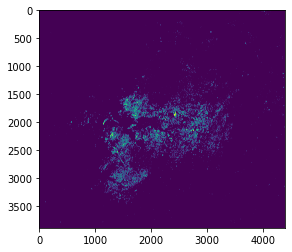

In [ ]:
#Convert Inventory from raster to array
inv = gdal.Open("MyDrive/Colab_Data/inventories_iburi_2018.tif")
invarray = inv.ReadAsArray()
invarray = invarray.reshape(1,invarray.shape[0],invarray.shape[1])
print("The number of dimensions is:",invarray.ndim)
print("The shape of the image is:",invarray.shape)
print("The minimum value is:",np.min(invarray))
print("The mean value is:", np.mean(invarray))
print("The maximum value is:",np.max(invarray))

#print image to check
plt.imshow(invarray[0])
plt.show()

#### Converting the array datasets into smaller patches and keras usable formats.

Code adapted from: https://github.com/ashokdahal/BurntAreaMapping_AIA/blob/main/Main%20Codes/Model_1_Code.ipynb


In [ ]:
#convert data into smaller patches and keras usable formats
Patchsize = 32            #amount of pixels in x and y direction
NBands = data_all.shape[0]

def gridwise_sample(imgarray, Patchsize, nbandsh):
    """Extract sample patches of size patchsize x patchsize from an image (imgarray) in a gridwise manner."""
    nbands, ncols,nrows = imgarray.shape
    patchsamples = np.zeros(shape=(0, nbandsh, Patchsize, Patchsize),
                            dtype=imgarray.dtype)
    for i in range(int(ncols/Patchsize)):
        print("patch column line %i out of %i" % (i,int(ncols/Patchsize)))
        for j in range(int(nrows/Patchsize)):
            tocat = imgarray[ : , i*Patchsize:(i+1)*Patchsize,
                             j*Patchsize:(j+1)*Patchsize]
            tocat = np.expand_dims(tocat, axis=0)
            patchsamples = np.concatenate((patchsamples, tocat),
                                          axis=0)
    return patchsamples

Xtrain = np.zeros(shape=(0, NBands, Patchsize, Patchsize), dtype=np.float32)
Ytrain = np.zeros(shape=(0, 1, Patchsize, Patchsize), dtype=np.uint8)
Xtrain_nls = np.zeros(shape=(0, NBands, Patchsize, Patchsize), dtype=np.float32)
Ytrain_nls = np.zeros(shape=(0, 1, Patchsize, Patchsize), dtype=np.uint8)


# sample each training tile systematically in a gridwise manner
X_toadd = gridwise_sample(data_all, Patchsize,NBands)
Y_toadd = gridwise_sample(invarray, Patchsize,1)
Xtrain = np.concatenate((Xtrain, X_toadd), axis=0)
Ytrain = np.concatenate((Ytrain, Y_toadd), axis=0)

patch column line 0 out of 121
patch column line 1 out of 121
patch column line 2 out of 121
patch column line 3 out of 121
patch column line 4 out of 121
patch column line 5 out of 121
patch column line 6 out of 121
patch column line 7 out of 121
patch column line 8 out of 121
patch column line 9 out of 121
patch column line 10 out of 121
patch column line 11 out of 121
patch column line 12 out of 121
patch column line 13 out of 121
patch column line 14 out of 121
patch column line 15 out of 121
patch column line 16 out of 121
patch column line 17 out of 121
patch column line 18 out of 121
patch column line 19 out of 121
patch column line 20 out of 121
patch column line 21 out of 121
patch column line 22 out of 121
patch column line 23 out of 121
patch column line 24 out of 121
patch column line 25 out of 121
patch column line 26 out of 121
patch column line 27 out of 121
patch column line 28 out of 121
patch column line 29 out of 121
patch column line 30 out of 121
patch column line 

In [ ]:
#Filter the patches to no water and at least one landslide present for each patch
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.compat.v1.Session(config=config))

#define indexes
index_nols = 0
index_ls = 0

#Define patch counting
n_patch_nols = 0
n_patch_ls = 0

#Count amount of landslide patches and no landslide patches
for i in reversed(range(Xtrain.shape[0])):
  numlspix = len(Ytrain[i][Ytrain[i]==1])   #landslides occurring
  numnan = np.sum(np.isnan(Xtrain[i]))      #removing nan values (where water is present)
  if numnan > 0:
    True
  elif(numlspix == 0):
    n_patch_nols = n_patch_nols + 1
  else:
    n_patch_ls = n_patch_ls + 1

#define empty array for landslide not present and present
Xtrain_n_nols = np.zeros(shape=(n_patch_nols, NBands, Patchsize, Patchsize), dtype=np.float32)
Ytrain_n_nols = np.zeros(shape=(n_patch_nols, 1, Patchsize, Patchsize), dtype=np.uint8)

Xtrain_n_ls = np.zeros(shape=(n_patch_ls, NBands, Patchsize, Patchsize), dtype=np.float32)
Ytrain_n_ls = np.zeros(shape=(n_patch_ls, 1, Patchsize, Patchsize), dtype=np.uint8)


#Change to only patches with landslides having occurred and no water present (nan values removed)
for i in reversed(range(Xtrain.shape[0])):
  numlspix = len(Ytrain[i][Ytrain[i]==1])   #landslides occurring
  numnan = np.sum(np.isnan(Xtrain[i]))      #removing nan values (where water is present)
  if numnan > 0:
    True
  elif(numlspix == 0):
    Xtrain_n_nols[index_nols] = Xtrain[i]
    Ytrain_n_nols[index_nols] = Ytrain[i]
    index_nols = index_nols+1
  else:
    Xtrain_n_ls[index_ls] = Xtrain[i]
    Ytrain_n_ls[index_ls] = Ytrain[i] 
    index_ls = index_ls+1

print("Patches with ls: %i " % (len(Xtrain_n_ls)))
print("Patches with no ls: %i " % (len(Xtrain_n_nols)))

#Amount of training patches
print("There are %i number of training patches." % (Xtrain.shape[0]))

#Checking amount of landslide and non-landslide pixels
nb_px=len(Ytrain[Ytrain==0])/(len(Ytrain[Ytrain==1])+len(Ytrain[Ytrain==0]))
yb_px=len(Ytrain[Ytrain==1])/(len(Ytrain[Ytrain==1])+len(Ytrain[Ytrain==0]))
print("there are %f percent pixels of landslide pixels and %f percent pixels of no landslide pixels." % (yb_px*100,nb_px*100) )

patches with ls 3360 
patches with no ls 11695 
There are 16577 number of training patches
there are 1.689022 percent pixels of landslide pixels and 98.310978 percent pixels of no landslide pixels


####Swapping the layer order
Which is needed for the correct format (patches x rows x columns x bands) for the model and is done by using numpy.swapaxes.

In [ ]:
#Swap order of layers
#RGB and NDVI Pre- and post-event
print(Xtrain_n_ls.shape)
Xtrain_n_ls = np.swapaxes(Xtrain_n_ls,1,3)
Xtrain_n_ls = np.swapaxes(Xtrain_n_ls,1,2)
print(Xtrain_n_ls.shape)
#Inventory
print(Ytrain_n_ls.shape)
Ytrain_n_ls = np.swapaxes(Ytrain_n_ls,1,3)
print(Ytrain_n_ls.shape)
#original dataset
print(Xtrain.shape)
Xtrain_swp = np.swapaxes(Xtrain,1,3)
Xtrain_swp = np.swapaxes(Xtrain_swp,1,2)
print(Xtrain_swp.shape)

(3360, 10, 32, 32)
(3360, 32, 32, 10)
(3360, 1, 32, 32)
(3360, 32, 32, 1)
(16577, 10, 32, 32)
(16577, 32, 32, 10)


####Creating the training and testing data

In [ ]:
#Creating the training and testing data
print(Xtrain_n_ls.shape)     #RGB+NDVI+DEM+Slope data
print(Ytrain_n_ls.shape)     #Validation data

#Split for Testing data in same area
Train_ds = Xtrain_n_ls[:2830,:]            #Manually split into 80% (Same for Validation_ds)
Validation_ds = Ytrain_n_ls[:2830,:]       
Test_ds = Xtrain_n_ls[2831:,:]             #Manually split into the other 20%
print("The shape of the training dataset is:",Train_ds.shape)
print("The shape of the validation dataset is:",Validation_ds.shape)
print("The shape of the test dataset is:",Test_ds.shape)

(3360, 32, 32, 10)
(3360, 32, 32, 1)
The shape of the training dataset is: (2830, 32, 32, 10)
The shape of the validation dataset is: (2830, 32, 32, 1)
The shape of the test dataset is: (529, 32, 32, 10)


### Creating the Model

The created model with TensorFlow is adapted from: https://github.com/ashokdahal/BurntAreaMapping_AIA/blob/main/Main%20Codes/Model_1_Code.ipynb.

The input data should consist of 32x32x10, where each patch has at least one landslide, and the 10 layers consist of pre- and post-event RGB and NDVI as well as the DEM and Slope. The output should consist of 32x32x1, with a probability for the landslides.



In [ ]:
#Use and adapt model
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
set_session(tf.compat.v1.Session(config=config))

NUMBER_BANDS = NBands
NUMBER_CLASSES = 1
Patchsize2 = Patchsize

def build_FCN(optimizer, Patchsize, Patchsize2, NBands):
    """Function to create Keras model of sample network."""
    model = keras.models.Sequential()
    model.add(ZeroPadding2D((3, 3), input_shape=(Patchsize, Patchsize, NUMBER_BANDS)))
    model.add(Convolution2D(
              filters=64,
              kernel_size=(7, 7),
              dilation_rate=(1, 1)))
    model.add(BatchNormalization(axis=3))         
    model.add(Activation("relu"))
    model.add(ZeroPadding2D((1, 1)))
    model.add(MaxPooling2D(
              pool_size=(3, 3),
              strides=(1, 1)
    ))
    model.add(ZeroPadding2D((2, 2)))
    model.add(Convolution2D(
              filters=64,
              kernel_size=(5, 5),
              dilation_rate=(1, 1)
    ))
    model.add(BatchNormalization(axis=3))
    model.add(Activation("relu"))
    model.add(ZeroPadding2D((1, 1)))
    model.add(MaxPooling2D(
            pool_size=(3, 3),
            strides=(1, 1)
    ))
    model.add(keras.layers.Conv2D(
              filters=NUMBER_CLASSES,
              kernel_size=(1, 1)
    ))
    model.add(keras.layers.Activation(
              activation="relu"
    ))
    return model

fcn = build_FCN(opt, Patchsize, Patchsize, NUMBER_BANDS)

fcn.compile(optimizer='adam',
            loss='binary_crossentropy', 
            metrics=['accuracy'])

In [ ]:
#check how the model looks
fcn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 38, 38, 10)       0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        31424     
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 34, 34, 64)       0         
 ng2D)                                                           
                                                        

### Training the Model

In [ ]:
#Train the model
epochs = 50
def train(model, data, labels):
    hist = model.fit(x=data,
                     y=labels,
                     epochs=epochs)
    return hist

history = train(fcn, Train_ds, Validation_ds)


Epoch 1/50
89/89 [==============================] - 80s 887ms/step - loss: 1.4890 - accuracy: 0.8328
Epoch 2/50
89/89 [==============================] - 76s 848ms/step - loss: 0.4891 - accuracy: 0.9064
Epoch 3/50
89/89 [==============================] - 75s 844ms/step - loss: 0.6690 - accuracy: 0.8667
Epoch 4/50
89/89 [==============================] - 76s 851ms/step - loss: 0.5326 - accuracy: 0.8748
Epoch 5/50
89/89 [==============================] - 78s 860ms/step - loss: 0.3874 - accuracy: 0.9082
Epoch 6/50
89/89 [==============================] - 75s 842ms/step - loss: 0.3522 - accuracy: 0.9085
Epoch 7/50
89/89 [==============================] - 75s 837ms/step - loss: 0.3328 - accuracy: 0.9082
Epoch 8/50
89/89 [==============================] - 75s 840ms/step - loss: 0.3669 - accuracy: 0.8998
Epoch 9/50
89/89 [==============================] - 75s 839ms/step - loss: 0.3230 - accuracy: 0.9084
Epoch 10/50
89/89 [==============================] - 74s 836ms/step - loss: 0.3124 - accura

### Visualizing Training Results

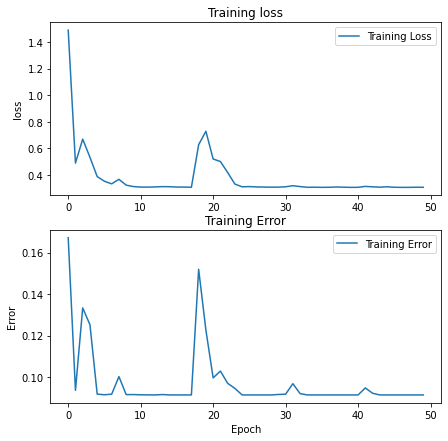

In [ ]:
# plot learning and error curves
epochs_range = range(epochs)
#Plot learning curve
plt.figure(figsize=(7,7))
plt.subplot(2,1,1)
plt.plot(epochs_range, history.history["loss"],label='Training Loss')
plt.title("Training loss")
plt.ylabel("loss")
#plt.xlabel("epoch")
#plt.plot(history.history["val_loss"],label='Validation Loss')
plt.legend()
#Plot error curve
plt.subplot(2,1,2)
plt.plot(epochs_range, 1-np.array(history.history["accuracy"]),label='Training Error')
plt.title("Training Error")
plt.ylabel("Error")
plt.xlabel("Epoch")
#plt.plot(1-np.array(history.history["val_acc"]),label='Validation Error')
plt.legend()
plt.show()

### Test Model on new data
Test the existing model on an area that the model hasn't seen before.

In [ ]:
#Use Test_ds for seeing how the model performs on data it hasn't seen before
print("The shape of the Test Dataset is:", Test_ds.shape) #Test_ds
predictions = fcn.predict(Test_ds)
predictions2 = fcn.predict(Xtrain_swp)
print("The shape of the Prediction Dataset is:",predictions.shape)
print("The shape of the Prediction2 Dataset is:",predictions2.shape)
#Show prediction for one patch
plt.imshow(predictions[0,:,:,0])
plt.show()

The shape of the Test Dataset is: (529, 32, 32, 10)
The shape of the Prediction Dataset is: (529, 32, 32, 1)
The shape of the Prediction2 Dataset is: (16577, 32, 32, 1)


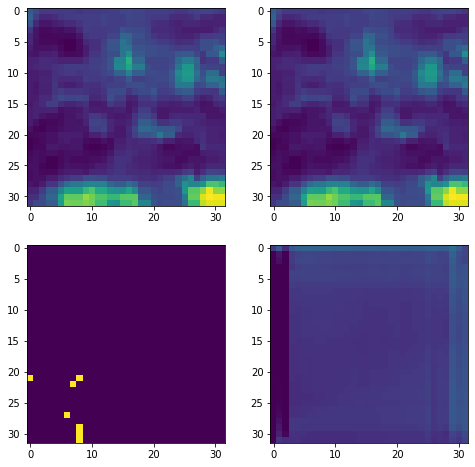

In [ ]:
#Plotting the pre-, post-images, Landslide Inventory and Predictions
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(8,8))
ax[0,0].imshow(Xtrain_n_ls[2831,:,:,4])    #RGB and NDVI pre-event (2831-3360)
ax[0,1].imshow(Xtrain_n_ls[2831,:,:,4])    #RGB and NDVI post-event (2831-3360)
ax[1,0].imshow(Ytrain_n_ls[2831,:,:,0])    #Landslide Inventory (2831-3360)
ax[1,1].imshow(predictions2[2831,:,:,0], vmin=0, vmax=1)    #Predictions for whole dataset (0-3360)
plt.show()

### Saving the trained and tested model.

In [ ]:
#Save the trained network
import imp, h5py
imp.reload(h5py)
model_name = "MyDrive/Colab_Data/LS_Det.hd5"
fcn.save(model_name)

INFO:tensorflow:Assets written to: MyDrive/Colab_Data/LS_Det.hd5/assets


#### Opening the trained and tested model
Opening the saved model, which is a h5 file.

In [ ]:
#Open saved model, so creating model step is not needed every time
from tensorflow import keras
fcn = keras.models.load_model('MyDrive/Colab_Data/LS_Det_A.hd5')
fcn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 38, 38, 10)       0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        31424     
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 34, 34, 64)       0         
 ng2D)                                                           
                                                        

### Creating the complete image
Let the model predict the landslide probability for the whole study area of Iburi-Tobu on Hokkaido, Japan.

In [ ]:
#Define empty prediction image
pred = np.zeros(shape=(data_all.shape[1],data_all.shape[2]), dtype=np.float32)

#Divide the length of x and y by 16 for amount of times kernal goes over dataset
num_patch_pred_x = math.floor(data_all.shape[1]/16)
num_patch_pred_y = math.floor(data_all.shape[2]/16)

#Loop for making prediction map with the correct kernel size
for i in range(0,num_patch_pred_x):
  for j in range(0,num_patch_pred_y):
    pred_in = np.zeros(shape=(1,32,32,10), dtype=np.float32)
    for l in range(0,32):
      for k in range(0,32):
        for m in range(0,8):
          pred_in[0][l][k][m] = data_all[m][min(data_all.shape[1]-1,max(0,i * 16 + l-8))][min(data_all.shape[2] -1,max(0,j*16+k-8))]
    predictions = fcn.predict(pred_in)
    for l in range(0,16):
      for k in range(0,16):
        pred[i * 16 + l][j*16+k] = predictions[0][8+l][8+k][0]


In [ ]:
#Remove zero and infinite values from prediction map
for i in range(0,data_all.shape[1]):
  for j in range(0,data_all.shape[2]):
    if np.isnan(pred[i][j]) or not np.isfinite(pred[i][j]):
      pred[i][j] = 0

The shape is: (1297, 1466)
The minimum value is: 0.0
The mean value is: 0.06018109
The maximum value is: 0.071814306


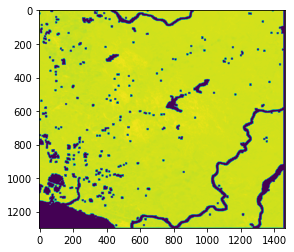

In [ ]:
#Checking the dimensions of the complete prediction map
print("The shape is:",pred.shape)
print("The minimum value is:",pred.min())
print("The mean value is:",pred.mean())
print("The maximum value is:",pred.max())
#Plotting the complete prediction map
plt.imshow(pred)
plt.show()

###Download and Save the complete image

Possibly for analysis in GIS.

In [ ]:
#Define missing inputs
dst_filename = "MyDrive/Colab_Data/Landslide_Prediction_30m.tif"
x_pixels = pred.shape[1]  # number of pixels in y
y_pixels = pred.shape[0]  # number of pixels in x
#Create the new image to which the array will be loaded
driver = gdal.GetDriverByName('GTiff')
dataset = driver.Create(dst_filename, x_pixels, y_pixels, 1, gdal.GDT_Float32)
#load the array to image
dataset.GetRasterBand(1).WriteArray(pred)

#Adding GeoTranform and Projection from dts (original dataset)
geotransform = dts.GetGeoTransform() 
proj = dts.GetProjection()
dataset.SetGeoTransform(geotransform)
dataset.SetProjection(proj)
dataset.FlushCache()
dataset=None

(3891, 4396)


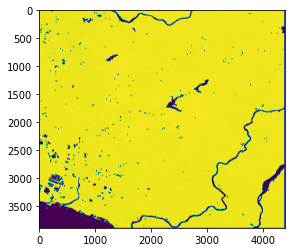

In [ ]:
#Open the calculated Landslide detection
LS_Detec = gdal.Open("MyDrive/Colab_Data/Landslide_Prediction_4C.tif")
LS_Pred = LS_Detec.ReadAsArray()
print("The shape of the predicted image is:",LS_Pred.shape)
plt.imshow(LS_Pred)
plt.show()

##ROC curve and AUC for testing the Model Validation


15842151   281947     975911   0.06
15836729   281935     981333   0.06003030303030303
15830479   281924     987583   0.06006060606060606
15822936   281906     995126   0.06009090909090909
15813780   281883     1004282   0.06012121212121212
15803687   281846     1014375   0.06015151515151515
15792285   281807     1025777   0.06018181818181818
15779037   281762     1039025   0.06021212121212121
15763949   281725     1054113   0.06024242424242424
15746601   281633     1071461   0.06027272727272727
15727148   281557     1090914   0.0603030303030303
15704790   281439     1113272   0.06033333333333333
15679879   281282     1138183   0.06036363636363636
15651186   281057     1166876   0.06039393939393939
15618514   280857     1199548   0.06042424242424242
15581343   280618     1236719   0.060454545454545455
15539806   280337     1278256   0.06048484848484848
15492923   280055     1325139   0.060515151515151515
15439707   279668     1378355   0.06054545454545454
15380329   279292     1437733 

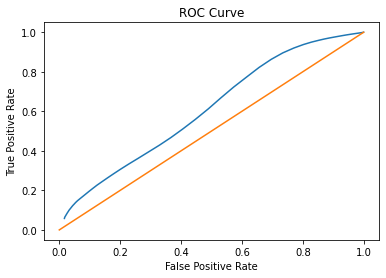

The Area Under Curve (AUC) is: 0.6098326110414631


In [ ]:
threshold_start = 0.06 
threshold_end = 0.063
num_samples = 100

fpr = np.array([])
tpr = np.array([])

auc = 0.0

fpr_prev = 0.0
tpr_prev = 0.0

for i in range(0,num_samples):
  threshold = threshold_start + (threshold_end-threshold_start) * float(i)/(float(num_samples-1))

  TP = 0
  FP  = 0
  TN = 0
  FN  = 0

  for j in range(0,data_all.shape[1]):
    for k in range(0,data_all.shape[2]):
      modelb = LS_Pred[j][k] < threshold
      obsb = invarray[0][j][k] < 0.5

      if modelb and obsb:
        TP = TP + 1               
      elif modelb and not obsb:
        FP = FP + 1
      elif not modelb and obsb:
        FN = FN + 1
      else:
        TN = TN + 1

  TPR = TP/(TP + FN) #TP/P
  TNR = TN/(FP + TN) #TN/N

  auc = auc +  (1.0-TNR - fpr_prev)*(0.5*(tpr_prev+TPR))

  fpr = np.append(fpr,1.0-TNR)
  tpr = np.append(tpr,TPR)
  fpr_prev = 1.0-TNR
  tpr_prev = TPR

  print(FN," ",TN, " ", " " , TP, " " , threshold)

#Plotting and printing the ROC curve and AUC value
fig, ax = plt.subplots()
line_up, = ax.plot([0,1], label='Comparison Line')
line_down, = ax.plot(fpr,tpr, color = 'red', label='ROC Curve')
blue_line = mlines.Line2D([fpr], [tpr], color='blue', label='Comparison Line')
red_line = mlines.Line2D([fpr], [tpr], color='red', label='ROC Curve')
ax.legend(handles=[red_line, blue_line])
plt.show()
print("The Area Under Curve (AUC) is:",auc)